In [1]:
from __future__ import unicode_literals

import sys
from os.path import join as pjoin
import pandas as pd
from pandas import DataFrame, Series
from boltons.fileutils import mkdir_p

sys.path.append('..')  # To locate camelid
from camelid.run import CamelidEnv

# CASRN - PubChem CID alignment workflow

This is based on the earlier notebook `CML CASRN-CID alignment homework.ipynb`, and is a prototype for an almost-fully automated process.

## Goal

Take the output from PubChem ID Exchange conversion of all CASRNs in the CML into CIDs, and determine whether each association is acceptable to use as a more-or-less definitive mapping, or requires further resolution.

This program categorizes ID associations as:

- **resolved (1:1)** - 1:1 mappings
- **resolved (1:n)** - 1:n CASRN:CID where all substances in the group share the same structural skeleton.
- **unresolved (1:n)** - 1:n CASRN:CID mappings where there are different 
- **unresolved (n:m)** - n:m CASRN:CID mappings where n > 1.

## Data source

1. List of CASRN that need to be mapped onto to PubChem CIDs.

2. CASRN:CID mappings output from PubChem. This dataset needs to be created by doing the following:
    - Upload the CASRN list into [PubChem ID Exchange](https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi), with the following settings:
        - **Input ID List: Synonyms; choose file** `base_casrn` or what have you.
        - Operator type: Same CID
        - **Output IDs: CIDs**
        - Output method: Two column...
        - Compression: Gzip

    Save the resulting file, for example, in `cmlbase/data/casrn_cid.gz` and unzip it: `gzip -d casrn_cid.gz` to get a file simply called `casrn_cid`. It should be a simple tab-separated value file.

3. CID:InChIKey mappings from PubChem, for the CIDs that are included in the above dataset. To get this:
    - Create a text file containing a list of just the CIDs from the CASRN:CID mappings. This can be done by importing the list as a spreadsheet and selecting only the CID column, or by running:
        `awk -F '\t' '{print $2}' casrn_cid > cids`.
    - Upload the CID list into [PubChem ID Exchange](https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi), with the following settings:
        - **Input ID List: CIDs; choose file** `cids` or what have you.
        - Operator type: Same CID
        - **Output IDs: InChIKeys**
        - Output method: Two column...
        - Compression: Gzip

    Save the resulting file, for example, in `cmlbase/data/cid_inchikey.gz` and unzip it: `gzip -d cid_inchikey.gz` to get a file simply called `cid_inchikey`. It should be a simple tab-separated value file.

# Setup

Create a camelid environment to store data, results, and logs. Specify path to input file.

In [2]:
env = CamelidEnv(project='cmlbase')
CASRN_CID_FILE = pjoin(env.data_path, 'casrn_cid')
CID_INCHIKEY_FILE = pjoin(env.data_path, 'cid_inchikey')

2017-01-13 17:44:31,792 camelid INFO Project path: /opt/akokai/data/camelid/cmlbase


# Step 0. Combine data sources into a DataFrame

Create a DataFrame `ids` from the CASRN:CIDs correspondences, which will be subject to further analysis.
- Eliminate null values which result from absence of a match in PubChem ID Exchange.
- Drop duplicates.
- Sort by CASRN and CID (not necessary, just makes it neater).

In [3]:
ids = pd.read_table(CASRN_CID_FILE, sep='\t', names=['CASRN', 'CID'], dtype=str)
ids = ids.dropna().drop_duplicates().sort_values(by=['CASRN', 'CID']).reset_index(drop=True)
print(len(ids), "initial CASRN:CID correspondences")
ids.head()

37336 initial CASRN:CID correspondences


,CASRN,CID
0,100-00-5,7474
1,100-01-6,7475
2,100-02-7,980
3,100-06-1,7476
4,100-07-2,7477


## Add a status column

The value of `status` will distinguish different levels of confidence in the mappings, based on the analysis below.

In [4]:
ids.insert(2, 'status', None)

## Add InChIKeys

Create another DataFrame of CID:InChIKey mappings; likewise eliminate null values and drop duplicates. We will only be using this DataFrame to map InChIKeys onto the CIDs in the `ids` table.

In [5]:
cid_inchikey = pd.read_table(CID_INCHIKEY_FILE, sep='\t', names=['CID', 'inchikey'], dtype=str)
cid_inchikey = cid_inchikey.dropna().drop_duplicates()
print(len(cid_inchikey), 'CID:InChIKey mappings')
cid_inchikey.head()

35944 CID:InChIKey mappings


,CID,inchikey
0,80101,YAWYUSRBDMEKHZ-UHFFFAOYSA-N
1,8779,LQPLDXQVILYOOL-UHFFFAOYSA-I
2,85128,DUYCTCQXNHFCSJ-UHFFFAOYSA-N
3,32611,LCZVSXRMYJUNFX-UHFFFAOYSA-N
4,16640,KFUSXMDYOPXKKT-UHFFFAOYSA-N


### Map InChIKeys onto CIDs in the main DataFrame

In [6]:
inchikeys = cid_inchikey.iloc[:,[0,1]]
ids = ids.merge(inchikeys, on='CID', how='inner')
print(len(ids), "identifier correspondences with InChIKeys")
ids.head()

37336 identifier correspondences with InChIKeys


,CASRN,CID,status,inchikey
0,100-00-5,7474,None,CZGCEKJOLUNIFY-UHFFFAOYSA-N
1,100-01-6,7475,None,TYMLOMAKGOJONV-UHFFFAOYSA-N
2,100-02-7,980,None,BTJIUGUIPKRLHP-UHFFFAOYSA-N
3,100-06-1,7476,None,NTPLXRHDUXRPNE-UHFFFAOYSA-N
4,100-07-2,7477,None,MXMOTZIXVICDSD-UHFFFAOYSA-N


# Step 1. Find mappings that are already 1:1

We will accept as valid all 1:1 CID:CASRN mappings output by PubChem.

## Calculate degrees of mapping for each ID

Determine which IDs are mapped 1:1, ..., n:m. Compute two values for each row:

- For every CASRN, how many CIDs have been associated with that CASRN? Call this `n_cid_casrn`.
- For every CID, how many CASRNs have been associated with that CID? Call this `n_casrn_cid`.

Compute these values for each *unique* CASRN or CID, and then add the appropriate corresponding value to every (CASRN, CID) row in the DataFrame.

In [7]:
# Compute number of CIDs for each unique CASRN.
n_cid_casrn = ids[['CASRN', 'CID']].groupby('CASRN').count()
ids['n_cid_casrn'] = ids['CASRN'].apply(lambda x: n_cid_casrn.loc[x, 'CID'])

# Compute number of CASRNs for each unique CID.
n_casrn_cid = ids[['CASRN', 'CID']].groupby('CID').count()
ids['n_casrn_cid'] = ids['CID'].apply(lambda x: n_casrn_cid.loc[x, 'CASRN'])

ids.head()

,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid
0,100-00-5,7474,None,CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1
1,100-01-6,7475,None,TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1
2,100-02-7,980,None,BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1
3,100-06-1,7476,None,NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1
4,100-07-2,7477,None,MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1


### Plot [optional]

Histograms of CAS and CID degrees-of-mapping show that this dataset is predominantly 1:1 mapping.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9c9c4b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1e996a0dd8>]], dtype=object)

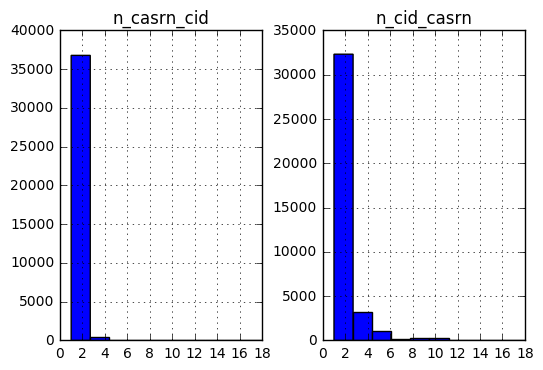

In [8]:
%matplotlib inline
ids.hist(column=['n_cid_casrn', 'n_casrn_cid'])

## Identify the 1:1 mappings

In [9]:
# Note: Avoiding assigning slices of DataFrames to variables
# (except for the purpose of printing length and showing examples).
# Keeping the analysis all inside the one DataFrame makes it easier
# and less confusing to produce a single set of results at the end.

ids.ix[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn == 1), 'status'] = 'resolved (1:1)'

mapped11 = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn == 1)]
print(len(mapped11), '1:1 CASRN:CID mappings') 
mapped11.head()

28078 1:1 CASRN:CID mappings


,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid
0,100-00-5,7474,resolved (1:1),CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1
1,100-01-6,7475,resolved (1:1),TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1
2,100-02-7,980,resolved (1:1),BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1
3,100-06-1,7476,resolved (1:1),NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1
4,100-07-2,7477,resolved (1:1),MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1


### Plot degrees of remaining n:m correspondences [optional]

The rest of the `ids` DataFrame contains associations for which there is either more than one CID, more than one CASRN, or both. Here are histograms of CAS and CID degrees-of-mapping once we have removed 1:1 mappings.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e995a8e80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9950b9e8>]], dtype=object)

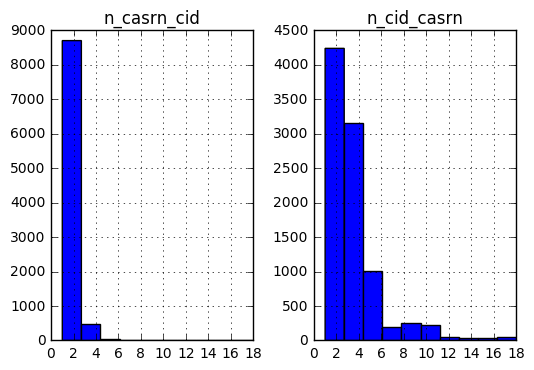

In [10]:
# %matplotlib inline
ids[(ids.n_casrn_cid > 1) | (ids.n_cid_casrn > 1)].hist(column=['n_cid_casrn', 'n_casrn_cid'])

# Step 2. Find 1:n CASRN:CID mappings that are structually feasible

### Goal

Accept CASRN-CID mappings where multiple CIDs were associated to a single CASRN (i.e., none of those CIDs were associated with other CASRNs), *and* all of those CIDs represent compounds having the same structural skeleton (excluding steroisomerism, tautomerism, ionization, etc.).

### Selection logic

The following test to determines whether to accept a CASRN:CID correspondence:

1. the number of CASRNs associated with the CID is 1 (below, `n_casrn_cid == 1`); AND
2. the number of unique structural skeletons associated with the CASRN throughout the whole dataset is 1 (below, `n_key_casrn` == 1).

### Outline of the code below

- Use the pandas `groupby` and `nunique` methods to determine how many unique base structures are associated with each CASRN (via the CIDs).
- Apply the selection logic to determine which IDs can be mapped acceptably, and which cannot.

## Isolate the structural base layer from each InChIKey

Create a new column containing only the first 14 characters of each InChIKey string; see the [InChI Technical FAQ](http://www.inchi-trust.org/technical-faq/) for details.

In [11]:
ids['key'] = ids['inchikey'].apply(lambda x: str(x)[:14])
ids.head()

,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid,key
0,100-00-5,7474,resolved (1:1),CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1,CZGCEKJOLUNIFY
1,100-01-6,7475,resolved (1:1),TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1,TYMLOMAKGOJONV
2,100-02-7,980,resolved (1:1),BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1,BTJIUGUIPKRLHP
3,100-06-1,7476,resolved (1:1),NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1,NTPLXRHDUXRPNE
4,100-07-2,7477,resolved (1:1),MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1,MXMOTZIXVICDSD


## Compute number of unique base structures for each group of 1:n CASRN:CIDs

For every CASRN, how many unique structural skeletons have been associated with that CASRN in the dataset? Call this number `n_key_casrn`. 

**This must be computed using the whole dataset! (Not just for the set of 1:n associations.) Otherwise the results are meaningless.**

In [12]:
n_key_casrn = ids[['CASRN', 'key']].groupby('CASRN')['key'].nunique()
ids['n_key_casrn'] = ids['CASRN'].apply(lambda x: n_key_casrn[x])
ids.head()

,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid,key,n_key_casrn
0,100-00-5,7474,resolved (1:1),CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1,CZGCEKJOLUNIFY,1
1,100-01-6,7475,resolved (1:1),TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1,TYMLOMAKGOJONV,1
2,100-02-7,980,resolved (1:1),BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1,BTJIUGUIPKRLHP,1
3,100-06-1,7476,resolved (1:1),NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1,NTPLXRHDUXRPNE,1
4,100-07-2,7477,resolved (1:1),MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1,MXMOTZIXVICDSD,1


### Tell me how many 1:n associations there are in total

In [13]:
print(len(ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1)]),
      'CASRN:CID associations with multiple CIDs')

6697 CASRN:CID associations with multiple CIDs


### Plot distribution of number of unique base-structures per CASRN in the 1:n set [optional]

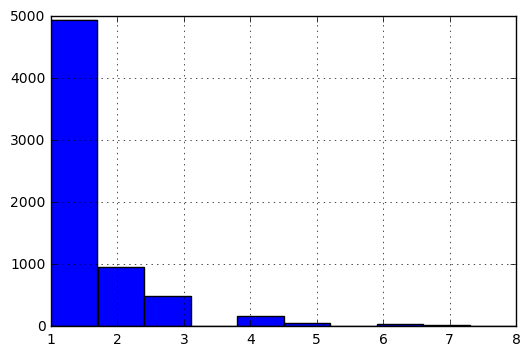

In [15]:
ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1)].n_key_casrn.hist()

Drop the `key` column, which is redundant even for visual inspection.

In [16]:
ids.drop('key', axis=1, inplace=True)

## Apply the test condition to find acceptable 1:n mappings

In [17]:
ids.ix[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1) & (ids.n_key_casrn == 1), 'status'] = 'resolved (1:n)'

mapped1n = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1) & (ids.n_key_casrn == 1)]
print(len(mapped1n), '1:n CASRN:CID associations sharing the same base structure per CASRN')
mapped1n.head()

4936 1:n CASRN:CID associations sharing the same base structure per CASRN


,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid,n_key_casrn
81,10016-20-3,24796,resolved (1:n),HFHDHCJBZVLPGP-JSPYPFAESA-N,6,1,1
82,10016-20-3,320760,resolved (1:n),HFHDHCJBZVLPGP-UHFFFAOYSA-N,6,1,1
83,10016-20-3,444913,resolved (1:n),HFHDHCJBZVLPGP-RWMJIURBSA-N,6,1,1
84,10016-20-3,46936256,resolved (1:n),HFHDHCJBZVLPGP-KREQUGERSA-N,6,1,1
85,10016-20-3,60041304,resolved (1:n),HFHDHCJBZVLPGP-DPHWATJASA-N,6,1,1


In [18]:
df = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1) & (ids.n_key_casrn == 1)]
print(len(df))

4936


In [19]:
ids.ix[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1) & (ids.n_key_casrn > 1), 'status'] = 'unresolved (1:n)'

unmapped1n = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1) & (ids.n_key_casrn > 1)]
print(len(unmapped1n), '1:n CASRN:CID associations with more than one base structure per CASRN')
unmapped1n.head()

1761 1:n CASRN:CID associations with more than one base structure per CASRN


,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid,n_key_casrn
463,10127-27-2,44134500,unresolved (1:n),WQCHYPQBLJBMMY-UHFFFAOYSA-M,2,1,2
464,10127-27-2,82375,unresolved (1:n),DFUHZEIMQHFCKR-UHFFFAOYSA-J,2,1,2
472,10134-33-5,101813503,unresolved (1:n),ZFTFEZINIDLJDJ-UHFFFAOYSA-K,2,1,2
473,10134-33-5,109374080,unresolved (1:n),GUSKQSPAKNSQCV-PLEQCSJPSA-N,2,1,2
566,10197-71-4,18764219,unresolved (1:n),IZUPJOYPPLEPGM-UHFFFAOYSA-N,4,1,3


# Step 3. Identify unresolved n:m mappings

In [20]:
ids.ix[(ids.n_casrn_cid > 1), 'status'] = 'unresolved (n:m)'

unmappednm = ids[(ids.n_casrn_cid > 1)]
print(len(unmappednm), 'unresolved n:m CASRN:CID associations')
unmappednm.head()

2561 unresolved n:m CASRN:CID associations


,CASRN,CID,status,inchikey,n_cid_casrn,n_casrn_cid,n_key_casrn
27,100-41-4,7500,unresolved (n:m),YNQLUTRBYVCPMQ-UHFFFAOYSA-N,1,4,1
28,27536-89-6,7500,unresolved (n:m),YNQLUTRBYVCPMQ-UHFFFAOYSA-N,1,4,1
29,68908-88-3,7500,unresolved (n:m),YNQLUTRBYVCPMQ-UHFFFAOYSA-N,1,4,1
30,70955-17-8,7500,unresolved (n:m),YNQLUTRBYVCPMQ-UHFFFAOYSA-N,1,4,1
31,100-42-5,7501,unresolved (n:m),PPBRXRYQALVLMV-UHFFFAOYSA-N,1,3,1


# Step 3. Combine and output results

Make sure that all entries have been categorized as to their `status`.

In [21]:
assert True not in ids['status'].isnull().values

Output to Excel.

In [23]:
ids.to_excel(pjoin(env.results_path, 'CASRN_CID_mapping.xlsx'), index=False)

Output to CSV only the CASRN, CID, and status columns.

In [24]:
ids[['CASRN', 'CID', 'status']].to_csv((pjoin(env.results_path, 'CASRN_CID_mapping.csv')), index=False)